# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

train_datagen_flow = datagen.flow_from_dataframe(
    labels,
    '/datasets/faces/final_files',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'raw',
    subset = 'training',
    seed = 42)

val_datagen_flow = datagen.flow_from_dataframe(
    labels,
    '/datasets/faces/final_files',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'raw',
    subset = 'validation',
    seed = 42)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [5]:
features, target = next(train_datagen_flow)

In [6]:
features.shape

(16, 224, 224, 3)

In [7]:
total_images = len(labels)
print("Всего изображений в датасете:", total_images)

Всего изображений в датасете: 7591


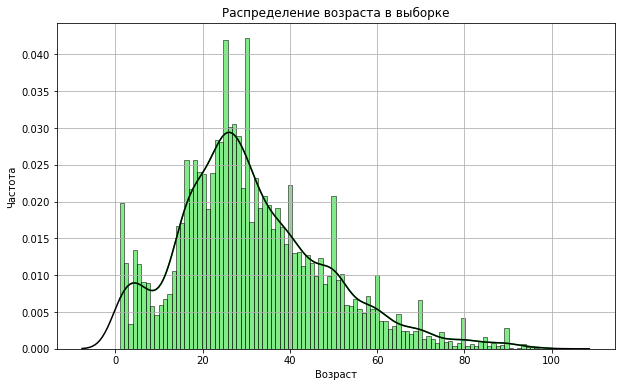

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, color='#05D912', kde=True, stat='density')
sns.kdeplot(labels['real_age'], color='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid()
plt.show()

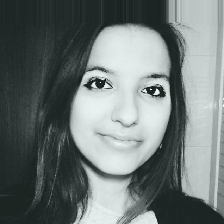

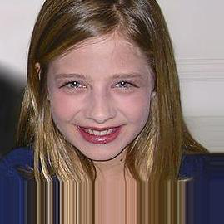

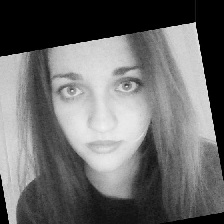

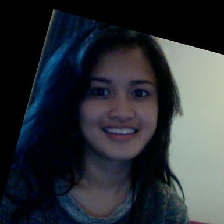

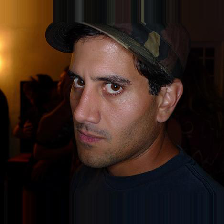

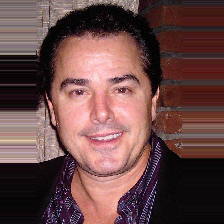

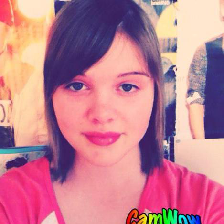

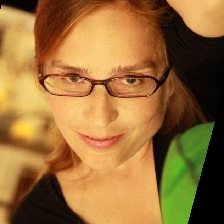

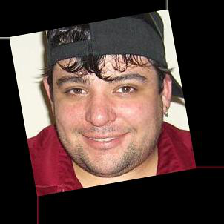

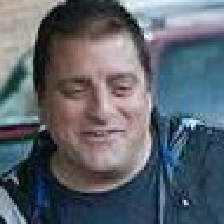

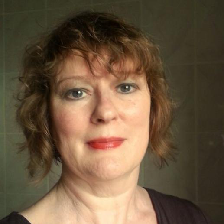

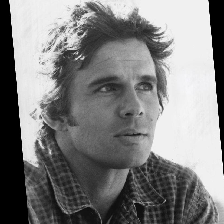

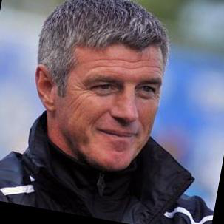

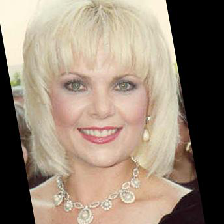

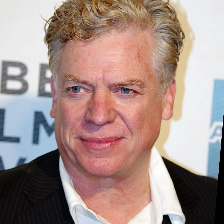

In [9]:
for i in range(15):
    img = Image.fromarray((features[i] * 255).astype('uint8')) 
    img.show() 

Вывод:
* распределение возраста в данных неравномерно, это может привести к смещению модели
* не все изображения в хорошем ракурсе, это также может повлиять на точность
* объем данных достаточно большой для обучения

## Обучение модели на GPU

In [10]:
def load_train(path):
    labels_path = os.path.join(path, 'labels.csv')
    images_path = os.path.join(path, 'final_files')

    labels = pd.read_csv(labels_path)
    datagen_train = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.25, rotation_range=20, zoom_range=0.1)

    train_datagen_flow = datagen_train.flow_from_dataframe(
        labels,
        images_path,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="training",
        seed=12345,
    )

    return train_datagen_flow

In [11]:
def load_test(path):
    labels_path = os.path.join(path, 'labels.csv')
    images_path = os.path.join(path, 'final_files')

    labels = pd.read_csv(labels_path)
    datagen_test = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.25)

    test_datagen_flow = datagen_test.flow_from_dataframe(
        labels,
        images_path,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="validation",
        seed=12345,
    )

    return test_datagen_flow

In [12]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0007)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

Вывод: метрика mae на тестовой выборке меньше 8

## Анализ модели

В ходе проекта была создана модель, которая по фотографии сможет предсказать возраст покупателя. Для работы использовался набор фотографий людей с указанием их реального возраста. Основная цель — предсказать числовое значение возраста на основе изображения. 


Исследовательский анализ данных:
* Количество фотографий в наборе данных - 7591
* Распределение возрастов: больше всего людей в возрасте от 20 до 40 лет
* Размер изображений - 224 x 224 пикселя

Обучение модели:
* Все значения пикселей в изображениях нормализованы
* Случайный поворот изображений в пределах ±20 градусов и случайное увеличение или уменьшение масштаба изображения на 10%
* Использование предобученной модели ResNet50.
* Добавление одного выходного нейрона для задачи регрессии
* Функция потерь - MSE

Оценка качества модели:
* Метрика MAE на тестовой выборке - 7.4206

В рамках данного проекта удалось создать модель, способную по фотографии предсказывать возраст человека. Использование предобученной сети ResNet50 позволило сократить время на обучение и добиться точных предсказаний.